# Preliminary testing on `Wang2023Better_WRN-70-16` robust model

Tested on `Python3.9`

Note that `timm` has conflict with current HuggingFace package. It is the package for loading pre-trained models from hugging face.

```
pip install --upgrade pip
pip install -r requirements.txt
```

In [1]:
import os

from art.estimators.classification import PyTorchClassifier
from autoattack import AutoAttack
from robustbench.data import load_cifar10
from robustbench.utils import load_model
from torchmetrics import Accuracy
import art.attacks.evasion as evasion
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
import torchvision.transforms as T


In [2]:
MODEL_NAME = 'Wang2023Better_WRN-70-16'
model = load_model(model_name=MODEL_NAME, dataset='cifar10', threat_model='Linf')

In [3]:
# For getting the classes only
transform = {
    'train': T.Compose([
        T.RandomResizedCrop(size=(32, 32)),
        T.RandomHorizontalFlip(p=0.5),
        T.ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4)),
        T.ToTensor(),
    ]),
    'val': T.Compose([
        T.Resize(size=32),
        T.CenterCrop(size=(32, 32)),
        T.ToTensor(),
    ])
}

dataset_test = tv.datasets.CIFAR10('./data', download=True, train=False, transform=transform['val'])

Files already downloaded and verified


In [4]:
classes = dataset_test.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
N_TEST = 100
N_CLASSES = 10
X_test, y_test = load_cifar10(n_examples=N_TEST)

Files already downloaded and verified


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
model = model.to(device)

In [8]:
# Testing the built-in auto attack
adversary = AutoAttack(model, norm='Linf', eps=8/255, version='custom', attacks_to_run=['apgd-ce', 'apgd-dlr'])
adversary.apgd.n_restarts = 1
# The results is confirmed with the BenchmarkTable
x_adv = adversary.run_standard_evaluation(X_test.to(device), y_test.to(device))

using custom version including apgd-ce, apgd-dlr.
initial accuracy: 95.00%
apgd-ce - 1/1 - 21 out of 95 successfully perturbed
robust accuracy after APGD-CE: 74.00% (total time 35.3 s)
apgd-dlr - 1/1 - 5 out of 74 successfully perturbed
robust accuracy after APGD-DLR: 69.00% (total time 60.3 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 69.00%


In [9]:
# Classifier wrapper for ATR

PIXEL_RANGE = (0., 1.)
INPUT_SHAPE = np.array(X_test.size())[1:]

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005, nesterov=True)
loss_fn = torch.nn.CrossEntropyLoss()
classifier = PyTorchClassifier(
    model=model,
    clip_values=PIXEL_RANGE,
    loss=criterion,
    optimizer=optimizer,
    input_shape=INPUT_SHAPE,
    nb_classes=10,
)

In [10]:
# Testing the ART implementation

# attack = evasion.AutoAttack(
#     estimator=classifier,
#     norm=np.inf,
#     eps=8 / 255,
#     eps_step=(8 / 255) / 10,
#     attacks=None,
#     batch_size=50,
#     estimator_orig=None,
# )
# X_advx = attack.generate(x=X_test.numpy())

# torch.save(X_advx, os.path.join('models', 'cifar10', 'Linf', 'X_advx.pt'))
# torch.save(X_test, os.path.join('models', 'cifar10', 'Linf', 'X_test.pt'))
# torch.save(y_test, os.path.join('models', 'cifar10', 'Linf', 'y_test.pt'))

In [11]:
# Matches the Benchmark results but Square Attack is much slower.

X_advx = torch.load(os.path.join('models', 'cifar10', 'Linf', 'X_advx.pt'))
X_test = torch.load(os.path.join('models', 'cifar10', 'Linf', 'X_test.pt'))
y_test = torch.load(os.path.join('models', 'cifar10', 'Linf', 'y_test.pt'))

# Don't need GPU to make predictions
model = model.to('cpu')
pred_advx = model(torch.FloatTensor(X_advx))
accuracy = Accuracy(task='multiclass', num_classes=N_CLASSES)
acc = accuracy(pred_advx, y_test)
print(f'Accuracy on AA: {acc*100:.2f}')

Accuracy on AA: 74.00


In [12]:
# Try CW Linf attack

# attack = evasion.CarliniLInfMethod(
#     classifier=classifier,
#     max_iter=10,
#     batch_size=1,
# )
# X_cw = attack.generate(x=X_test.numpy())
# torch.save(X_cw, os.path.join('models', 'cifar10', 'Linf', 'X_cw.pt'))

In [13]:
# Load CW Linf attacks

X_cw = torch.load(os.path.join('models', 'cifar10', 'Linf', 'X_cw.pt'))

print(f'X Range: [{X_test.min()}, {X_test.max()}]')
print(f'CW2 Range: [{X_cw.min()}, {X_cw.max()}]')

X Range: [0.0, 1.0]
CW2 Range: [0.0, 1.0]


In [14]:
# Matches the Benchmark results 

pred_cw = model(torch.Tensor(X_cw))
accuracy = Accuracy(task='multiclass', num_classes=N_CLASSES)
acc = accuracy(pred_cw.cpu(), y_test)

print(f'Accuracy on CW-Linf: {acc*100:.2f}')

Accuracy on CW-Linf: 69.00


In [16]:
# Try CW2 attack

# attack = evasion.CarliniL2Method(classifier=classifier)
# X_cw2 = attack.generate(x=X_test.numpy())

# torch.save(X_cw2, os.path.join('models', 'cifar10', 'Linf', 'X_cw2.pt'))

In [17]:
# Result is much worse
# Load CW2 attacks

X_cw2 = torch.load(os.path.join('models', 'cifar10', 'Linf', 'X_cw2.pt'))

model = model.to('cpu')
pred_advx = model(torch.Tensor(X_cw2))
accuracy = Accuracy(task='multiclass', num_classes=N_CLASSES)
acc = accuracy(pred_advx, y_test)
print(f'Accuracy on AA: {acc*100:.2f}')

Accuracy on AA: 8.00


In [18]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()

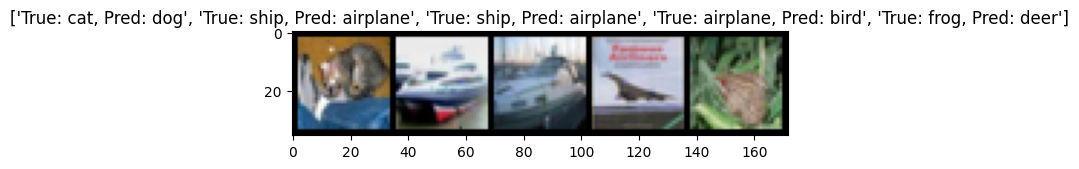

In [19]:
# Print the top 5 images

images = tv.utils.make_grid(torch.Tensor(X_cw2)[:5])
titles = [f'True: {classes[y]}, Pred: {classes[y_hat]}' for y, y_hat in zip(y_test[:5], pred_advx.argmax(1).numpy()[:5])]
imshow(images, title=titles)

In [20]:
# Check the range

print(f'X Range: [{X_test.min()}, {X_test.max()}]')
print(f'CW2 Range: [{X_cw2.min()}, {X_cw2.max()}]')

X Range: [0.0, 1.0]
CW2 Range: [0.0, 1.0]
